# Quadrupolar Coupling Demo PULSEE

# Imports

In [1]:
import numpy as np
import pandas as pd
from pulsee import simulation as sim, quantum_computing as qc, operators as op
import qutip as qt 
import matplotlib.pyplot as plt
import ipyparallel

# Parameters

In [2]:
Ix, Iy, Iz = qt.spin_J_set(3 / 2)

In [3]:
QUANTUM_NUMBERS = [3/2] # spin 1/2
GAMMA_2PIS = [5 / (2 * np.pi)] # = gamma / 2pi
B0 = 2 * np.pi
W0 = GAMMA_2PIS[0] * B0 * 2 * np.pi # Careful with the sign AND DON'T FORGET * 2PI (radial frequency)
B1 = 1e-1/1
zeem_par = {'field magnitude' : B0, 'theta_z' : 0, 'phi_z' : 0}

ACQUISITION_TIME = 50 # in microseconds
T2 = 10

h_dict = {
}

args = h_dict.copy()
spin_par = []
for qn, gam in zip(QUANTUM_NUMBERS, GAMMA_2PIS):
    spin_par.append({'quantum number': qn, 'gamma/2pi': gam})

quad_par = {'coupling constant' : 0.1,
                    'asymmetry parameter' : 0,
                    'alpha_q' : 0.,
                    'beta_q' : np.pi/2.,
                    'gamma_q' : 0.,
                    'order' : 0}

args['spin_par'] = spin_par 
args['zeem_par'] = zeem_par
args['quad_par'] = quad_par
# Initial state is canocial
spin, h_unperturbed, rho_0 = sim.nuclear_system_setup(**args)                                                   

In [4]:
etas = np.linspace(0, 1, 2)

# Simulation
Define simulation code which we will run with different solvers:

In [5]:
pulse_time = 2 / (4 * 3 * GAMMA_2PIS[0] * B1)
mode = pd.DataFrame([( B0 * GAMMA_2PIS[0], B1, 0., np.pi/2, 0, pulse_time)], 
                           columns=['frequency', 'amplitude', 'phase', 'theta_p', 'phi_p', 'pulse_time'], )

# Plots

Run simulations with Magnus solve

100%|██████████| 160/160 [00:00<00:00, 517.53it/s]


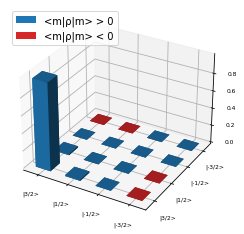

In [6]:
dm_evolved = sim.evolve(spin, h_unperturbed, rho_0, solver='magnus', \
                    mode=mode, \
                    picture = 'IP', n_points=160)
fig = sim.plot_real_part_density_matrix(dm_evolved)

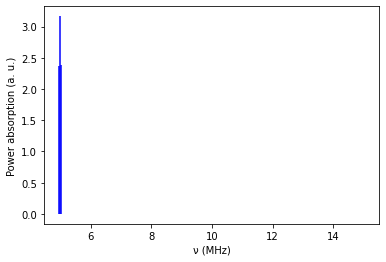

In [7]:
f, p = sim.power_absorption_spectrum(spin, h_unperturbed, normalized=True)
_ = sim.plot_power_absorption_spectrum(f, p)

/Users/Alex/Documents/GitHub/PULSEE/src/pulsee/simulation.py:1259: UserWarning: Unreliable FID: Weak signal, check simulation!
  warnings.warn('Unreliable FID: Weak signal, check simulation!', stacklevel=0)


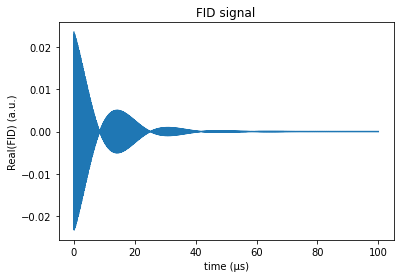

In [8]:
t, fid = sim.FID_signal(spin, h_unperturbed, dm_evolved, acquisition_time=100, T2=10, n_points=1000)

_ = sim.plot_real_part_FID_signal(t, fid)

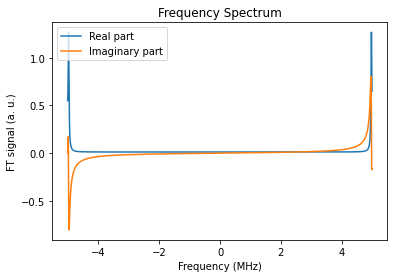

In [9]:
f, ft = sim.fourier_transform_signal(fid, t)

fig = sim.plot_fourier_transform(f, ft, norm=False)

Plot & solve mesolve solution QuTiP's [master equation solver](https://qutip.org/docs/latest/modules/qutip/mesolve.html#mesolve)::

10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.0%. Run time:   0.00s. Est. time left: 00:00:00:00
30.0%. Run time:   0.01s. Est. time left: 00:00:00:00
40.0%. Run time:   0.01s. Est. time left: 00:00:00:00
50.0%. Run time:   0.01s. Est. time left: 00:00:00:00
60.0%. Run time:   0.01s. Est. time left: 00:00:00:00
70.0%. Run time:   0.01s. Est. time left: 00:00:00:00
80.0%. Run time:   0.02s. Est. time left: 00:00:00:00
90.0%. Run time:   0.02s. Est. time left: 00:00:00:00
Total run time:   0.02s


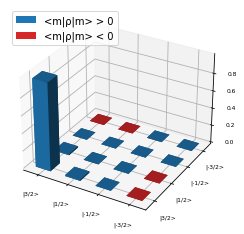

In [10]:
dm_evolved_mesolve = sim.evolve(spin, h_unperturbed, rho_0, solver='mesolve', \
                    mode=mode, \
                    picture = 'IP', n_points=160)
fig = sim.plot_real_part_density_matrix(dm_evolved)

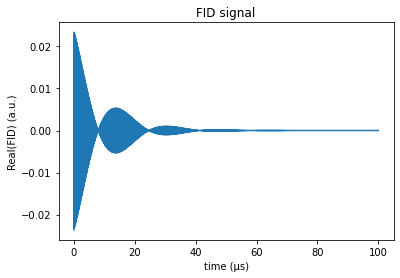

In [11]:
t, fid = sim.FID_signal(spin, h_unperturbed, dm_evolved_mesolve, acquisition_time=100, T2=10, n_points=1000)

_ = sim.plot_real_part_FID_signal(t, fid)

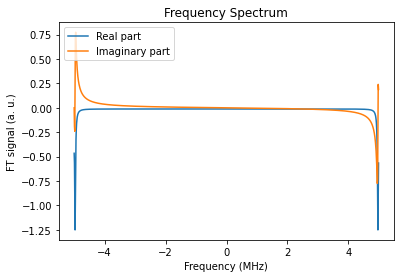

In [12]:
f, ft = sim.fourier_transform_signal(fid, t)

fig = sim.plot_fourier_transform(f, ft, norm=False)

One must experiment with the pulse duration to find the exact $\pi/2$ pulse. This is hard because of the presence of the Zeeman term in the Hamiltonian. The spins are rotating during the evolution of the pulse with respect to the applied field. This is why the peaks for the $\eta = 0$ case are not exacly symmetric. 

Simulate with exact diagonalization approach:

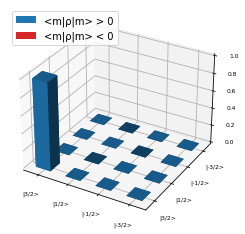

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 4000/4000 [00:00<00:00, 539217.59it/s]


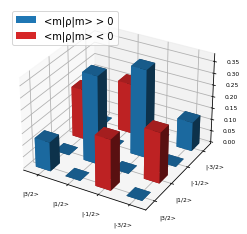

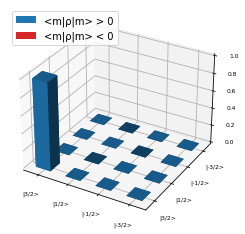

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 4000/4000 [00:00<00:00, 554545.38it/s]


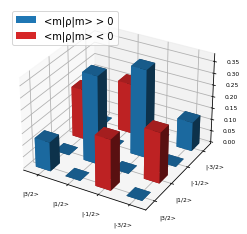

In [13]:
fts_ed = [] 

for eta in etas:
	quad_par = {'coupling constant' : 0.1,
				'asymmetry parameter' : eta,
				'alpha_q' : 0.,
				'beta_q' : np.pi/2,
				'gamma_q' : 0.,
				'order' : 0}

	spin, h_unperturbed, dm_initial = sim.nuclear_system_setup(spin_par, quad_par=quad_par, 
										zeem_par=zeem_par, initial_state='canonical', temperature=1e-5)
	fig = sim.plot_real_part_density_matrix(dm_initial)  
    
	t = np.linspace(0, 800, 5*800) # 50 second acquisition time, 1000 data points

	iz, ix, iy = (spin.I['z'], spin.I['x'], spin.I['y'])

	rot_dm = sim.apply_rot_pulse(dm_initial, np.pi/2, ix) # rotate about x axis
	dm_evolved, e_ops = sim.ed_evolve(h = h_unperturbed, rho0 = rot_dm, spin = spin, tlist = t, fid=True, parallel=True, T2=100)
	fig = sim.plot_real_part_density_matrix(dm_evolved)
	FID = e_ops[0]

	f, ft = sim.fourier_transform_signal(FID, t, padding=0)
	fts_ed.append([eta, f, ft, t, FID])

Plot exact diagonalization solution:

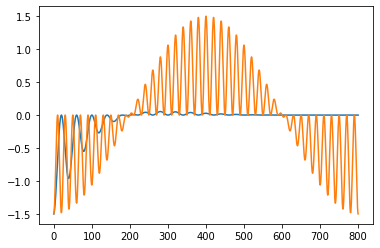

In [14]:
fig, ax = plt.subplots() 
for eta, f, ft, t, fid in fts_ed: 
	plt.plot(t, np.imag(fid))

Because of the idealized Ix pulse, exact diagonalization cannot exactly simulate experiments. 

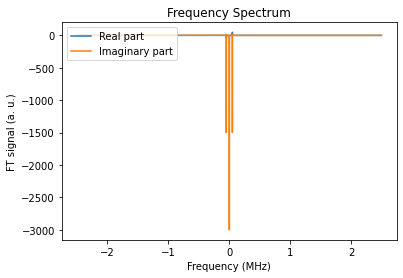

In [15]:
f, ft = sim.fourier_transform_signal(fid, t)

fig = sim.plot_fourier_transform(f, ft, norm=False)

Because of the instatenous pulse, we have an exact $\pi/2$ pulse and the peaks for the $\eta = 0$ case are symmetric around the central peak. 

Simulate with exact diagonalization approach \& 2 different stretched exponential decays:

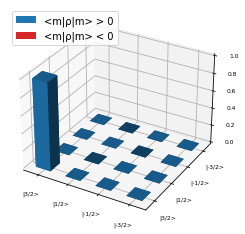

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.        0.8660254 0.        0.       ]
 [0.8660254 0.        1.        0.       ]
 [0.        1.        0.        0.8660254]
 [0.        0.        0.8660254 0.       ]] Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.+0.j        0.-0.8660254j 0.+0.j        0.+0.j       ]
 [0.+0.8660254j 0.+0.j        0.-1.j        0.+0.j       ]
 [0.+0.j        0.+1.j        0.+0.j        0.-0.8660254j]
 [0.+0.j        0.+0.j        0.+0.8660254j 0.+0.j       ]] Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.5  0.   0.   0. ]
 [ 0.   0.5  0.   0. ]
 [ 0.   0.  -0.5  0. ]
 [ 0.   0.   0.  -1.5]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 4000/4000 [00:00<00:00, 257066.93it/s]


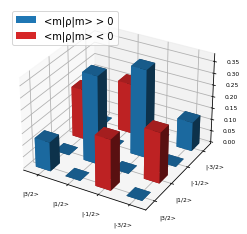

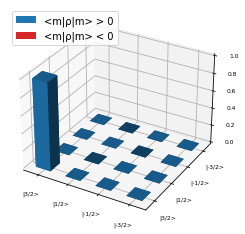

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.        0.8660254 0.        0.       ]
 [0.8660254 0.        1.        0.       ]
 [0.        1.        0.        0.8660254]
 [0.        0.        0.8660254 0.       ]] Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.+0.j        0.-0.8660254j 0.+0.j        0.+0.j       ]
 [0.+0.8660254j 0.+0.j        0.-1.j        0.+0.j       ]
 [0.+0.j        0.+1.j        0.+0.j        0.-0.8660254j]
 [0.+0.j        0.+0.j        0.+0.8660254j 0.+0.j       ]] Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.5  0.   0.   0. ]
 [ 0.   0.5  0.   0. ]
 [ 0.   0.  -0.5  0. ]
 [ 0.   0.   0.  -1.5]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 4000/4000 [00:00<00:00, 276897.44it/s]


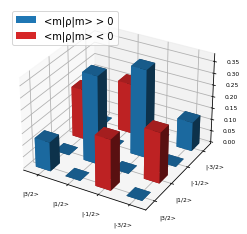

In [16]:
fts_ed = [] 

for eta in etas:
	quad_par = {'coupling constant' : 0.1,
				'asymmetry parameter' : eta,
				'alpha_q' : 0.,
				'beta_q' : np.pi/2,
				'gamma_q' : 0.,
				'order' : 0}

	spin, h_unperturbed, dm_initial = sim.nuclear_system_setup(spin_par, quad_par=quad_par, 
										zeem_par=zeem_par, initial_state='canonical', temperature=1e-5)

	fig = sim.plot_real_part_density_matrix(dm_initial)
    
	t = np.linspace(0, 800, 5*800) # 50 second acquisition time, 1000 data points

	ix, iy, iz = qt.spin_J_set(3 / 2)
 
	rot_dm = sim.apply_rot_pulse(dm_initial, np.pi/2, ix) # rotate about x axis
	dm_evolved, e_ops = sim.ed_evolve(h_unperturbed, rot_dm, spin, t, e_ops=[], fid=True, parallel=True, T2=[lambda t: np.exp(-(t/100)**1.5), lambda t: np.exp(-(t/100)**2)])
	fig = sim.plot_real_part_density_matrix(dm_evolved)
	FID = e_ops[0]

	f, ft = sim.fourier_transform_signal(FID, t, padding=0)
	fts_ed.append([eta, f, ft, t, FID])


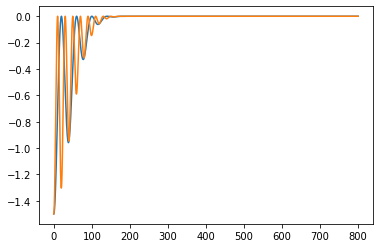

In [17]:
fig, ax = plt.subplots() 
for eta, f, ft, t, fid in fts_ed: 
	plt.plot(t, np.imag(fid))

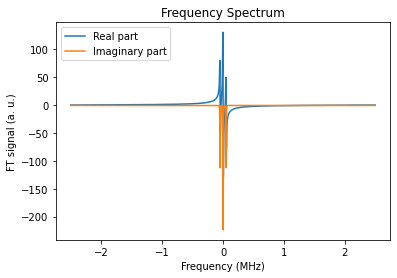

In [18]:
f, ft = sim.fourier_transform_signal(fid, t)

fig = sim.plot_fourier_transform(f, ft, norm=False)

The peaks here are broadened by two stetched exponentials $\exp(-(t/T_2)^\beta)$, where $T_2 = 100 \ \mu$s and $\beta = \{1.5, 2\}$.